In [122]:
import os
import random
import pandas as pd
from pathlib import Path
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.ndimage import gaussian_filter1d
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
)

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)
from side_info_decoding.reduced_rank import (
    Reduced_Rank_Model, 
    train_single_task, 
    model_eval,
    Multi_Task_Reduced_Rank_Model,
    train_multi_task
)

import pymc3 as pm
from hmmlearn import vhmm
from side_info_decoding.bmm_hmm import (
    BetaProcess, Constrained_BMM_HMM, posterior_inference
)
from side_info_decoding.viz import plot_multi_session_hmm_results, plot_bmm_hmm_results

seed = 666
set_seed(seed)

In [76]:
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 10
BIGGER_SIZE = 10
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 3

In [30]:
pids = ["523f8301-4f56-4faf-ab33-a9ff11331118"]

In [31]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="all",
    behavior="choice",
    data_type="all_ks",
    t_before=0.5,
    t_after=1.5,
    n_t_bins=40
)

pulling data from ibl database ..
eid: 88224abb-5746-431f-9c17-17d7ef806e6a
pid: 523f8301-4f56-4faf-ab33-a9ff11331118
number of trials found: 397
found 397 trials from 37.78 to 2183.45 sec.


Compute spike count: 100%|████████████████████| 397/397 [00:04<00:00, 83.43it/s]


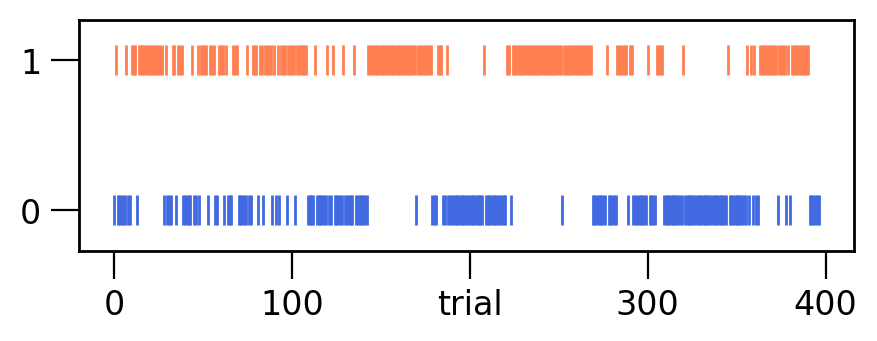

In [38]:
choices = Y_dict[pids[0]]

plt.figure(figsize=(5, 1.5))
plt.eventplot(
    np.where(choices == 1.), 
    colors="coral", lineoffsets=1, linelengths=.2, linewidth=1., 
)
plt.eventplot(
    np.where(choices == 0.), 
    colors="royalblue", lineoffsets=0, linelengths=.2, linewidth=1.,
)
plt.yticks([0, 1], [0, 1], fontsize=12)
plt.xticks([0, 100, 200, 300, 400], [0, 100, "trial", 300, 400], fontsize=12)
plt.savefig("./plots/observed_choice.png", dpi=100)
plt.show()

#### PCA vs. RRR 

In [32]:
example_pid = pids[0]

R = 3 # rank
d = 0 # half window size
n_epochs = 5000

# prepare data
X, Y = X_dict[example_pid], Y_dict[example_pid]
K, C, T = X.shape
X = sliding_window_over_trials(X, half_window_size=d)
Y = sliding_window_over_trials(Y, half_window_size=d)
X, Y = torch.tensor(X), torch.tensor(Y)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=0)

rrm = Reduced_Rank_Model(
    n_units=C, 
    n_t_bins=T, 
    rank=R, 
    half_window_size=d
)

# training
rrm, train_losses = train_single_task(
    model=rrm,
    train_dataset=(train_X, train_Y),
    test_dataset=(test_X, test_Y),
    loss_function=torch.nn.BCELoss(),
    learning_rate=1e-3,
    weight_decay=1e-1,
    n_epochs=n_epochs,
)

# eval
test_U, test_V, test_metrics, _ = model_eval(
    rrm, 
    train_dataset=(train_X, train_Y),
    test_dataset=(test_X, test_Y),
    behavior="choice"
)

Epoch [500/5000], Loss: 30.553320739906233
Epoch [1000/5000], Loss: 17.989543676747115
Epoch [1500/5000], Loss: 4.589138684646783
Epoch [2000/5000], Loss: 0.04089769200251604
Epoch [2500/5000], Loss: 0.04357803611718408
Epoch [3000/5000], Loss: 0.048309382189875766
Epoch [3500/5000], Loss: 0.048001292879687095
Epoch [4000/5000], Loss: 0.048563542188601067
Epoch [4500/5000], Loss: 0.04840459604329857
Epoch [5000/5000], Loss: 0.04786071401485677
train accuracy: 1.000 auc: 0.912
test accuracy: 0.912 auc: 0.970


In [33]:
U = rrm.U.detach().numpy().squeeze()
V = rrm.V.detach().numpy().squeeze()

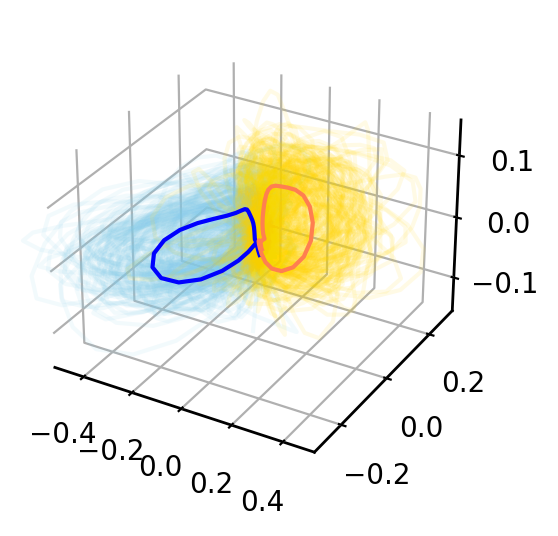

In [78]:
left_proj = (X[Y == 0].squeeze().transpose(-1,1) @ U) * V.squeeze().T
right_proj = (X[Y == 1].squeeze().transpose(-1,1) @ U) * V.squeeze().T

smooth_left_proj = np.array([[gaussian_filter1d(left_proj[k,:, r].squeeze(), 2.) for r in range(R)] for k in range(len(left_proj))])
smooth_right_proj = np.array([[gaussian_filter1d(right_proj[k,:, r].squeeze(), 2.) for r in range(R)] for k in range(len(right_proj))])

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(projection='3d')

for k in range(len(smooth_left_proj)):
    ax.plot(smooth_left_proj[k,0], smooth_left_proj[k,1], smooth_left_proj[k,2], c="skyblue", alpha=.1)

for k in range(len(smooth_right_proj)):
    ax.plot(smooth_right_proj[k,0], smooth_right_proj[k,1], smooth_right_proj[k,2], c="gold", alpha=.1)
    
ax.plot(smooth_left_proj.mean(0)[0], smooth_left_proj.mean(0)[1], smooth_left_proj.mean(0)[2], c="b")
ax.plot(smooth_right_proj.mean(0)[0], smooth_right_proj.mean(0)[1], smooth_right_proj.mean(0)[2], c="coral");
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.axes.set_xlim3d(left=-.5, right=.5)
ax.axes.set_ylim3d(bottom=-.3, top=.3)
ax.axes.set_zlim3d(bottom=-.15, top=.15);
# plt.savefig("./plots/RRR_latents.png", dpi=200)

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X.squeeze().reshape((-1,C)))

PCA(n_components=3)

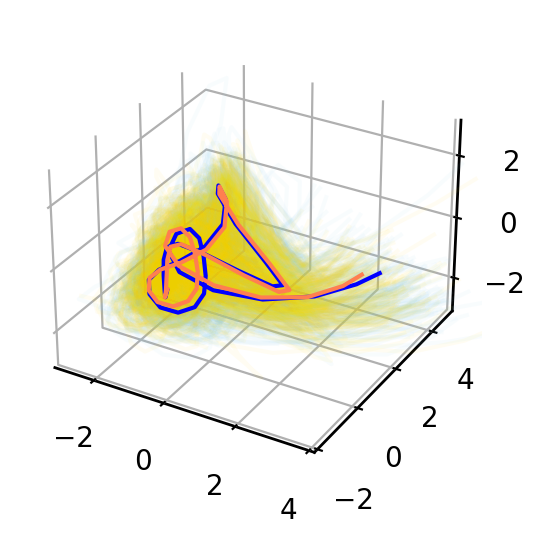

In [83]:
pca_left_proj = pca.transform(X[Y == 0].squeeze().reshape((-1,C))).reshape((-1,T,3))
pca_right_proj = pca.transform(X[Y == 1].squeeze().reshape((-1,C))).reshape((-1,T,3))

smooth_left_proj = np.array([[gaussian_filter1d(pca_left_proj[k,:, r].squeeze(), 2.) for r in range(R)] for k in range(len(pca_left_proj))])
smooth_right_proj = np.array([[gaussian_filter1d(pca_right_proj[k,:, r].squeeze(), 2.) for r in range(R)] for k in range(len(pca_right_proj))])

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(projection='3d')

for k in range(len(smooth_left_proj)):
    ax.plot(smooth_left_proj[k,0], smooth_left_proj[k,1], smooth_left_proj[k,2], c="skyblue", alpha=.05)

for k in range(len(smooth_right_proj)):
    ax.plot(smooth_right_proj[k,0], smooth_right_proj[k,1], smooth_right_proj[k,2], c="gold", alpha=.05)
    
ax.plot(smooth_left_proj.mean(0)[0], smooth_left_proj.mean(0)[1], smooth_left_proj.mean(0)[2], c="b")
ax.plot(smooth_right_proj.mean(0)[0], smooth_right_proj.mean(0)[1], smooth_right_proj.mean(0)[2], c="coral");
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.axes.set_xlim3d(left=-3, right=4)
ax.axes.set_ylim3d(bottom=-2, top=5)
ax.axes.set_zlim3d(bottom=-3, top=3);
# plt.savefig("./plots/PCA_latents.png", dpi=200)

#### RRR vs. multi-session RRR

In [214]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    '1e176f17-d00f-49bb-87ff-26d237b525f1',
    '16799c7a-e395-435d-a4c4-a678007e1550',
     'ad714133-1e03-4d3a-8427-33fc483daf1a',
     '31f3e083-a324-4b88-b0a4-7788ec37b191',
]

In [215]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="lp",
    behavior="choice",
    data_type="all_ks",
    t_before=0.5,
    t_after=1.5,
    n_t_bins=40
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367
found 367 trials from 17.56 to 2310.24 sec.
found 131 Kilosort units in region lp


Compute spike count: 100%|███████████████████| 367/367 [00:00<00:00, 906.86it/s]


pulling data from ibl database ..
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
number of trials found: 350
found 350 trials from 22.21 to 2393.54 sec.
found 74 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 350/350 [00:00<00:00, 3004.74it/s]


pulling data from ibl database ..
eid: dac3a4c1-b666-4de0-87e8-8c514483cacf
pid: 6fc4d73c-2071-43ec-a756-c6c6d8322c8b
number of trials found: 428
found 428 trials from 281.82 to 3112.92 sec.
found 70 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 428/428 [00:00<00:00, 2476.44it/s]


pulling data from ibl database ..
eid: 88224abb-5746-431f-9c17-17d7ef806e6a
pid: 523f8301-4f56-4faf-ab33-a9ff11331118
number of trials found: 397
found 397 trials from 37.78 to 2183.45 sec.
found 48 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 397/397 [00:00<00:00, 1722.48it/s]


pulling data from ibl database ..
eid: 3638d102-e8b6-4230-8742-e548cd87a949
pid: 143dd7cf-6a47-47a1-906d-927ad7fe9117
number of trials found: 605
found 605 trials from 32.91 to 4786.28 sec.
found 208 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 605/605 [00:00<00:00, 1246.32it/s]


pulling data from ibl database ..
eid: 51e53aff-1d5d-4182-a684-aba783d50ae5
pid: 1a60a6e1-da99-4d4e-a734-39b1d4544fad
number of trials found: 450
found 450 trials from 20.56 to 2612.19 sec.
found 109 Kilosort units in region lp


Compute spike count: 100%|███████████████████| 450/450 [00:00<00:00, 945.54it/s]


pulling data from ibl database ..
eid: a4a74102-2af5-45dc-9e41-ef7f5aed88be
pid: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a
number of trials found: 369
found 369 trials from 69.71 to 1863.38 sec.
found 123 Kilosort units in region lp


Compute spike count: 100%|███████████████████| 369/369 [00:00<00:00, 754.78it/s]


pulling data from ibl database ..
eid: a8a8af78-16de-4841-ab07-fde4b5281a03
pid: 1e176f17-d00f-49bb-87ff-26d237b525f1
number of trials found: 463
found 463 trials from 126.06 to 3721.10 sec.
found 63 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 463/463 [00:00<00:00, 1371.02it/s]


pulling data from ibl database ..
eid: 0a018f12-ee06-4b11-97aa-bbbff5448e9f
pid: 16799c7a-e395-435d-a4c4-a678007e1550
number of trials found: 417
found 417 trials from 124.50 to 2631.45 sec.
found 122 Kilosort units in region lp


Compute spike count: 100%|███████████████████| 417/417 [00:00<00:00, 959.99it/s]


pulling data from ibl database ..
eid: 8928f98a-b411-497e-aa4b-aa752434686d
pid: ad714133-1e03-4d3a-8427-33fc483daf1a
number of trials found: 583
found 583 trials from 112.34 to 3275.94 sec.
found 110 Kilosort units in region lp


Compute spike count: 100%|███████████████████| 583/583 [00:01<00:00, 346.31it/s]


pulling data from ibl database ..
eid: 61e11a11-ab65-48fb-ae08-3cb80662e5d6
pid: 31f3e083-a324-4b88-b0a4-7788ec37b191
number of trials found: 766
found 766 trials from 106.48 to 4386.99 sec.
found 143 Kilosort units in region lp


Compute spike count: 100%|███████████████████| 766/766 [00:02<00:00, 327.23it/s]


In [112]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="vis",
    behavior="choice",
    data_type="all_ks",
    t_before=0.5,
    t_after=1.5,
    n_t_bins=40
)

pulling data from ibl database ..
eid: dac3a4c1-b666-4de0-87e8-8c514483cacf
pid: 6fc4d73c-2071-43ec-a756-c6c6d8322c8b
number of trials found: 428
found 428 trials from 281.82 to 3112.92 sec.
found 15 Kilosort units in region vis


Compute spike count: 100%|██████████████████| 428/428 [00:00<00:00, 3949.21it/s]


In [268]:
example_pid = pids[5] 

R = 3 # rank
d = 0 # half window size
n_epochs = 5000

# prepare data
X, Y = X_dict[example_pid], Y_dict[example_pid]
K, C, T = X.shape
X = sliding_window_over_trials(X, half_window_size=d)
Y = sliding_window_over_trials(Y, half_window_size=d)
X, Y = torch.tensor(X), torch.tensor(Y)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=0)

rrm = Reduced_Rank_Model(
    n_units=C, 
    n_t_bins=T, 
    rank=R, 
    half_window_size=d
)

# training
rrm, train_losses = train_single_task(
    model=rrm,
    train_dataset=(train_X, train_Y),
    test_dataset=(test_X, test_Y),
    loss_function=torch.nn.BCELoss(),
    learning_rate=1e-3,
    weight_decay=1e-1,
    n_epochs=n_epochs,
)

# eval
test_U, test_V, test_metrics, _ = model_eval(
    rrm, 
    train_dataset=(train_X, train_Y),
    test_dataset=(test_X, test_Y),
    behavior="choice"
)

Epoch [500/5000], Loss: 18.293299518510803
Epoch [1000/5000], Loss: 5.59216388823018
Epoch [1500/5000], Loss: 0.1734317828706545
Epoch [2000/5000], Loss: 0.11979691787884003
Epoch [2500/5000], Loss: 0.13583125380928548
Epoch [3000/5000], Loss: 0.14053162663173782
Epoch [3500/5000], Loss: 0.1373739237959081
Epoch [4000/5000], Loss: 0.134271129114138
Epoch [4500/5000], Loss: 0.13105037061088415
Epoch [5000/5000], Loss: 0.12976108327812735
train accuracy: 0.997 auc: 0.811
test accuracy: 0.811 auc: 0.917


In [269]:
U = rrm.U.detach().numpy().squeeze()
V = rrm.V.detach().numpy().squeeze()

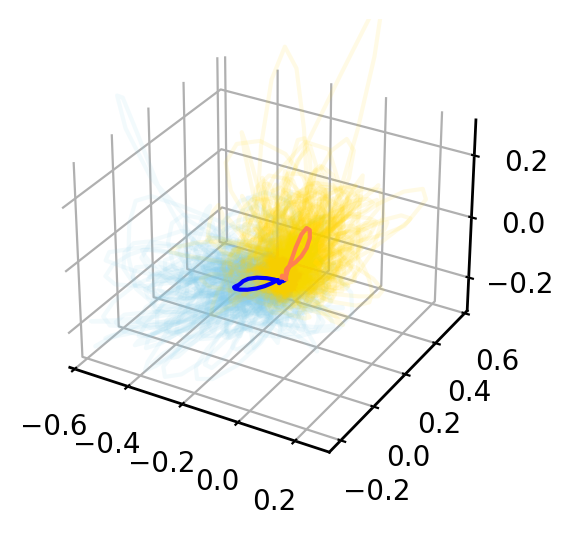

In [274]:
left_proj = (X[Y == 0].squeeze().transpose(-1,1) @ U) * V.squeeze().T
right_proj = (X[Y == 1].squeeze().transpose(-1,1) @ U) * V.squeeze().T

smooth_left_proj = np.array([[gaussian_filter1d(left_proj[k,:, r].squeeze(), 2.) for r in range(R)] for k in range(len(left_proj))])
smooth_right_proj = np.array([[gaussian_filter1d(right_proj[k,:, r].squeeze(), 2.) for r in range(R)] for k in range(len(right_proj))])

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(projection='3d')

for k in range(len(smooth_left_proj)):
    ax.plot(smooth_left_proj[k,0], smooth_left_proj[k,1], smooth_left_proj[k,2], c="skyblue", alpha=.1)

for k in range(len(smooth_right_proj)):
    ax.plot(smooth_right_proj[k,0], smooth_right_proj[k,1], smooth_right_proj[k,2], c="gold", alpha=.1)
    
ax.plot(smooth_left_proj.mean(0)[0], smooth_left_proj.mean(0)[1], smooth_left_proj.mean(0)[2], c="b")
ax.plot(smooth_right_proj.mean(0)[0], smooth_right_proj.mean(0)[1], smooth_right_proj.mean(0)[2], c="coral");
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.axes.set_xlim3d(left=-.6, right=.3)
ax.axes.set_ylim3d(bottom=-.25, top=.6)
ax.axes.set_zlim3d(bottom=-.3, top=.3);
plt.savefig(f"./plots/{example_pid}_latents.png", dpi=200)

In [281]:
X_dict_bkp = X_dict.copy()

In [ ]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="all",
    behavior="choice",
    data_type="all_ks",
    t_before=0.5,
    t_after=1.5,
    n_t_bins=40
)

In [283]:
X_dict[pids[4]] = X_dict_bkp[pids[4]]
X_dict[pids[5]] = X_dict_bkp[pids[5]]

In [285]:
R = 3 # rank
d = 0 # half window size
n_epochs = 7000

# prepare data
n_units = []
train_X_lst, train_Y_lst, test_X_lst, test_Y_lst = [], [], [], []
for pid in pids:
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=0)
    train_X_lst.append(train_X)
    train_Y_lst.append(train_Y)
    test_X_lst.append(test_X)
    test_Y_lst.append(test_Y)
    n_units.append(C)

    
multi_task_rrm = Multi_Task_Reduced_Rank_Model(
    n_tasks=len(pids),
    n_units=n_units, 
    n_t_bins=T, 
    rank=R, 
    half_window_size=d
)

# training
multi_task_rrm, train_losses = train_multi_task(
    model=multi_task_rrm,
    train_dataset=(train_X_lst, train_Y_lst),
    test_dataset=(test_X_lst, test_Y_lst),
    loss_function=torch.nn.BCELoss(),
    learning_rate=1e-3,
    weight_decay=1e-3,
    n_epochs=n_epochs,
)

Epoch [700/7000], Loss: 33.64440358322682
Epoch [1400/7000], Loss: 26.847078825119926
Epoch [2100/7000], Loss: 16.133676716809873
Epoch [2800/7000], Loss: 5.743982470998795
Epoch [3500/7000], Loss: 0.5455133499133996
Epoch [4200/7000], Loss: 0.014415062136512365
Epoch [4900/7000], Loss: 0.003778234482657967
Epoch [5600/7000], Loss: 0.0036667486518961855
Epoch [6300/7000], Loss: 0.003544723654271664
Epoch [7000/7000], Loss: 0.0034295175967035446


In [297]:
Us = [U.detach().numpy() for U in multi_task_rrm.Us]
V = multi_task_rrm.V.detach().numpy().squeeze()

In [287]:
from scipy.linalg import svd

In [288]:
svd_Us, svd_Vs = [], []
for i, pid in enumerate(pids):
    try:
        W = Us[i] @ V
        U_, S, V_ = svd(W)
        svd_Vs.append(np.diag(S[:3]) @ V_[:3, :])
        svd_Us.append(U_[:, :3] @ np.diag(S[:3]))
    except:
        pass
svd_Vs = np.array(svd_Vs)
svd_Us = np.array(svd_Us)

/tmp/ipykernel_71804/1976254537.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  svd_Us = np.array(svd_Us)


In [321]:
pid_idx = 4 #4, 5
example_pid = pids[pid_idx]
example_pid

X, Y = X_dict[example_pid], Y_dict[example_pid]
K, C, T = X.shape
X = sliding_window_over_trials(X, half_window_size=0)
Y = sliding_window_over_trials(Y, half_window_size=0)
U = svd_Us[pid_idx]
V = svd_Vs[pid_idx]

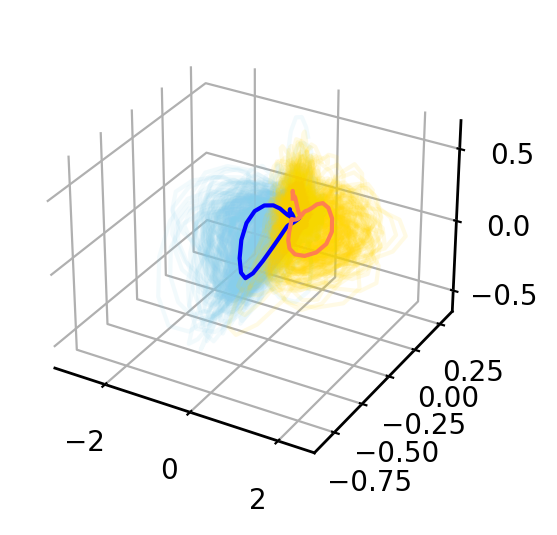

In [323]:
left_proj = (X[Y == 0].squeeze().transpose(0,-1,1) @ U) * V.squeeze().T
right_proj = (X[Y == 1].squeeze().transpose(0,-1,1) @ U) * V.squeeze().T

smooth_left_proj = np.array([[gaussian_filter1d(left_proj[k,:, r].squeeze(), 2.) for r in range(R)] for k in range(len(left_proj))])
smooth_right_proj = np.array([[gaussian_filter1d(right_proj[k,:, r].squeeze(), 2.) for r in range(R)] for k in range(len(right_proj))])

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(projection='3d')

for k in range(len(smooth_left_proj)):
    ax.plot(smooth_left_proj[k,0], smooth_left_proj[k,1], smooth_left_proj[k,2], c="skyblue", alpha=.1)

for k in range(len(smooth_right_proj)):
    ax.plot(smooth_right_proj[k,0], smooth_right_proj[k,1], smooth_right_proj[k,2], c="gold", alpha=.1)
    
ax.plot(smooth_left_proj.mean(0)[0], smooth_left_proj.mean(0)[1], smooth_left_proj.mean(0)[2], c="b")
ax.plot(smooth_right_proj.mean(0)[0], smooth_right_proj.mean(0)[1], smooth_right_proj.mean(0)[2], c="coral");
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.axes.set_xlim3d(left=-5, right=5)
# ax.axes.set_ylim3d(bottom=-2, top=3)
# ax.axes.set_zlim3d(bottom=-4, top=2);
# plt.savefig(f"./plots/{example_pid}_multi_sess_latents.png", dpi=200)

#### Fig 2

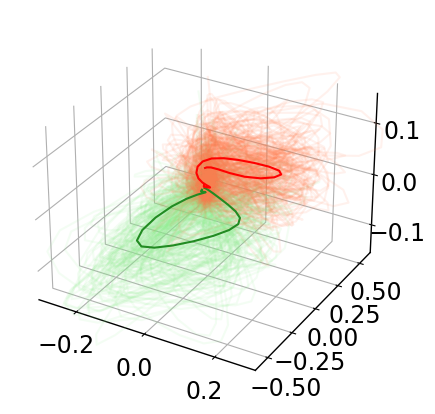

In [92]:
# plot for each trial - 

left_proj = (X[Y == 0].squeeze().transpose(-1,1) @ U) * V.squeeze().T
right_proj = (X[Y == 1].squeeze().transpose(-1,1) @ U) * V.squeeze().T

smooth_left_proj = np.array([[gaussian_filter1d(left_proj[k,:, r].squeeze(), 2.) for r in range(R)] for k in range(len(left_proj))])
smooth_right_proj = np.array([[gaussian_filter1d(right_proj[k,:, r].squeeze(), 2.) for r in range(R)] for k in range(len(right_proj))])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

for k in range(len(smooth_left_proj)):
    ax.plot(smooth_left_proj[k,0], smooth_left_proj[k,1], smooth_left_proj[k,2], c="lightgreen", alpha=.1)

for k in range(len(smooth_right_proj)):
    ax.plot(smooth_right_proj[k,0], smooth_right_proj[k,1], smooth_right_proj[k,2], c="coral", alpha=.1)
    
ax.plot(smooth_left_proj.mean(0)[0], smooth_left_proj.mean(0)[1], smooth_left_proj.mean(0)[2], c="forestgreen")
ax.plot(smooth_right_proj.mean(0)[0], smooth_right_proj.mean(0)[1], smooth_right_proj.mean(0)[2], c="r");
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.axes.set_xlim3d(left=-.3, right=.3)
ax.axes.set_ylim3d(bottom=-.6, top=.6)
ax.axes.set_zlim3d(bottom=-.15, top=.15)
plt.savefig("./plots/latent_dynamics_choice.png", dpi=200)

In [7]:
left_proj = X[Y == 0].squeeze().transpose(-1,1) @ U 
right_proj = X[Y == 1].squeeze().transpose(-1,1) @ U 

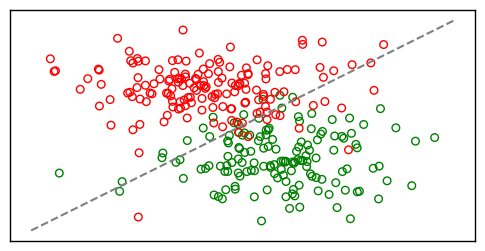

In [239]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.scatter(left_proj.mean(1)[:,0], left_proj.mean(1)[:,1], s=30, marker="o", facecolors='none', linewidths=1, edgecolors='g', label="left trial")
ax.scatter(right_proj.mean(1)[:,0], right_proj.mean(1)[:,1], s=30, marker="o", facecolors='none', linewidths=1, edgecolors='r', label="right trial")
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="gray")
# plt.xlabel("1st rank")
# plt.ylabel("2nd rank")
# plt.legend(frameon=False)
plt.xticks([], [])
plt.yticks([], [])
# plt.savefig("./plots/low_rank_proj_choice.png", dpi=200);

In [149]:
smooth_V = np.array([gaussian_filter1d(V[r, :].squeeze(), 4.) for r in range(R)])

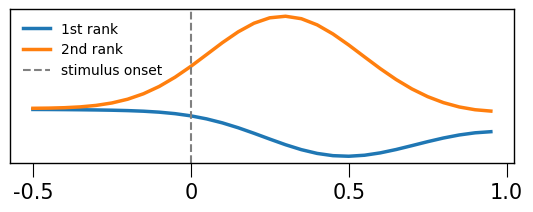

In [230]:
plt.figure(figsize=(6.5,2))
plt.plot(smooth_V[0], linewidth=2.5, label="1st rank")
plt.plot(smooth_V[1], linewidth=2.5, label="2nd rank")
plt.axvline(x=10, c="gray", linestyle="--", label="stimulus onset")
plt.xticks([0, 10, 20, 30], [-0.5, 0, 0.5, 1.0])
plt.yticks([], [])
plt.legend(fontsize=10, frameon=False)
# plt.savefig("./plots/low_rank_V_choice.png", dpi=200);

In [3]:
brain_region = "ca1"

dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    "16799c7a-e395-435d-a4c4-a678007e1550",
    "1e176f17-d00f-49bb-87ff-26d237b525f1",
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "31f3e083-a324-4b88-b0a4-7788ec37b191",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf",
    "ad714133-1e03-4d3a-8427-33fc483daf1a"
]

ys, ds = [], []
for _, pid in enumerate(pids):

    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"choice"/"all"/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        d.append(
            np.load(
                dir_path/pid/"choice"/brain_region/"y_prob"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"choice"/"all"/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx),1]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

/tmp/ipykernel_45208/1497462015.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array(ys)
/tmp/ipykernel_45208/1497462015.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds = np.array(ds)


In [4]:
# prepare training sessions and test session

test_pid_idx = 3
pid = pids[test_pid_idx]
print(pid)
print(brain_region)
d = ds[test_pid_idx].squeeze()
y = ys[test_pid_idx].squeeze()

save_path, save_metrics = {}, {}
out_path = Path("/home/yizi/side_info_decoding/saved_results")
for res in ["constrained_bmm_hmm_metrics", "constrained_bmm_hmm_figures"]:
    save_path.update({res: out_path/res/pid})
    os.makedirs(save_path[res], exist_ok=True)
    
train_pid_idxs = np.delete(np.arange(len(pids)), test_pid_idx)
train_ys, test_ys = ys[train_pid_idxs], ys[test_pid_idx]
train_ds, test_ds = ds[train_pid_idxs], ds[test_pid_idx]

aligned_train_ys = np.concatenate(train_ys)
lengths = [len(train_ys[idx]) for idx in range(len(train_ys))]

523f8301-4f56-4faf-ab33-a9ff11331118
ca1


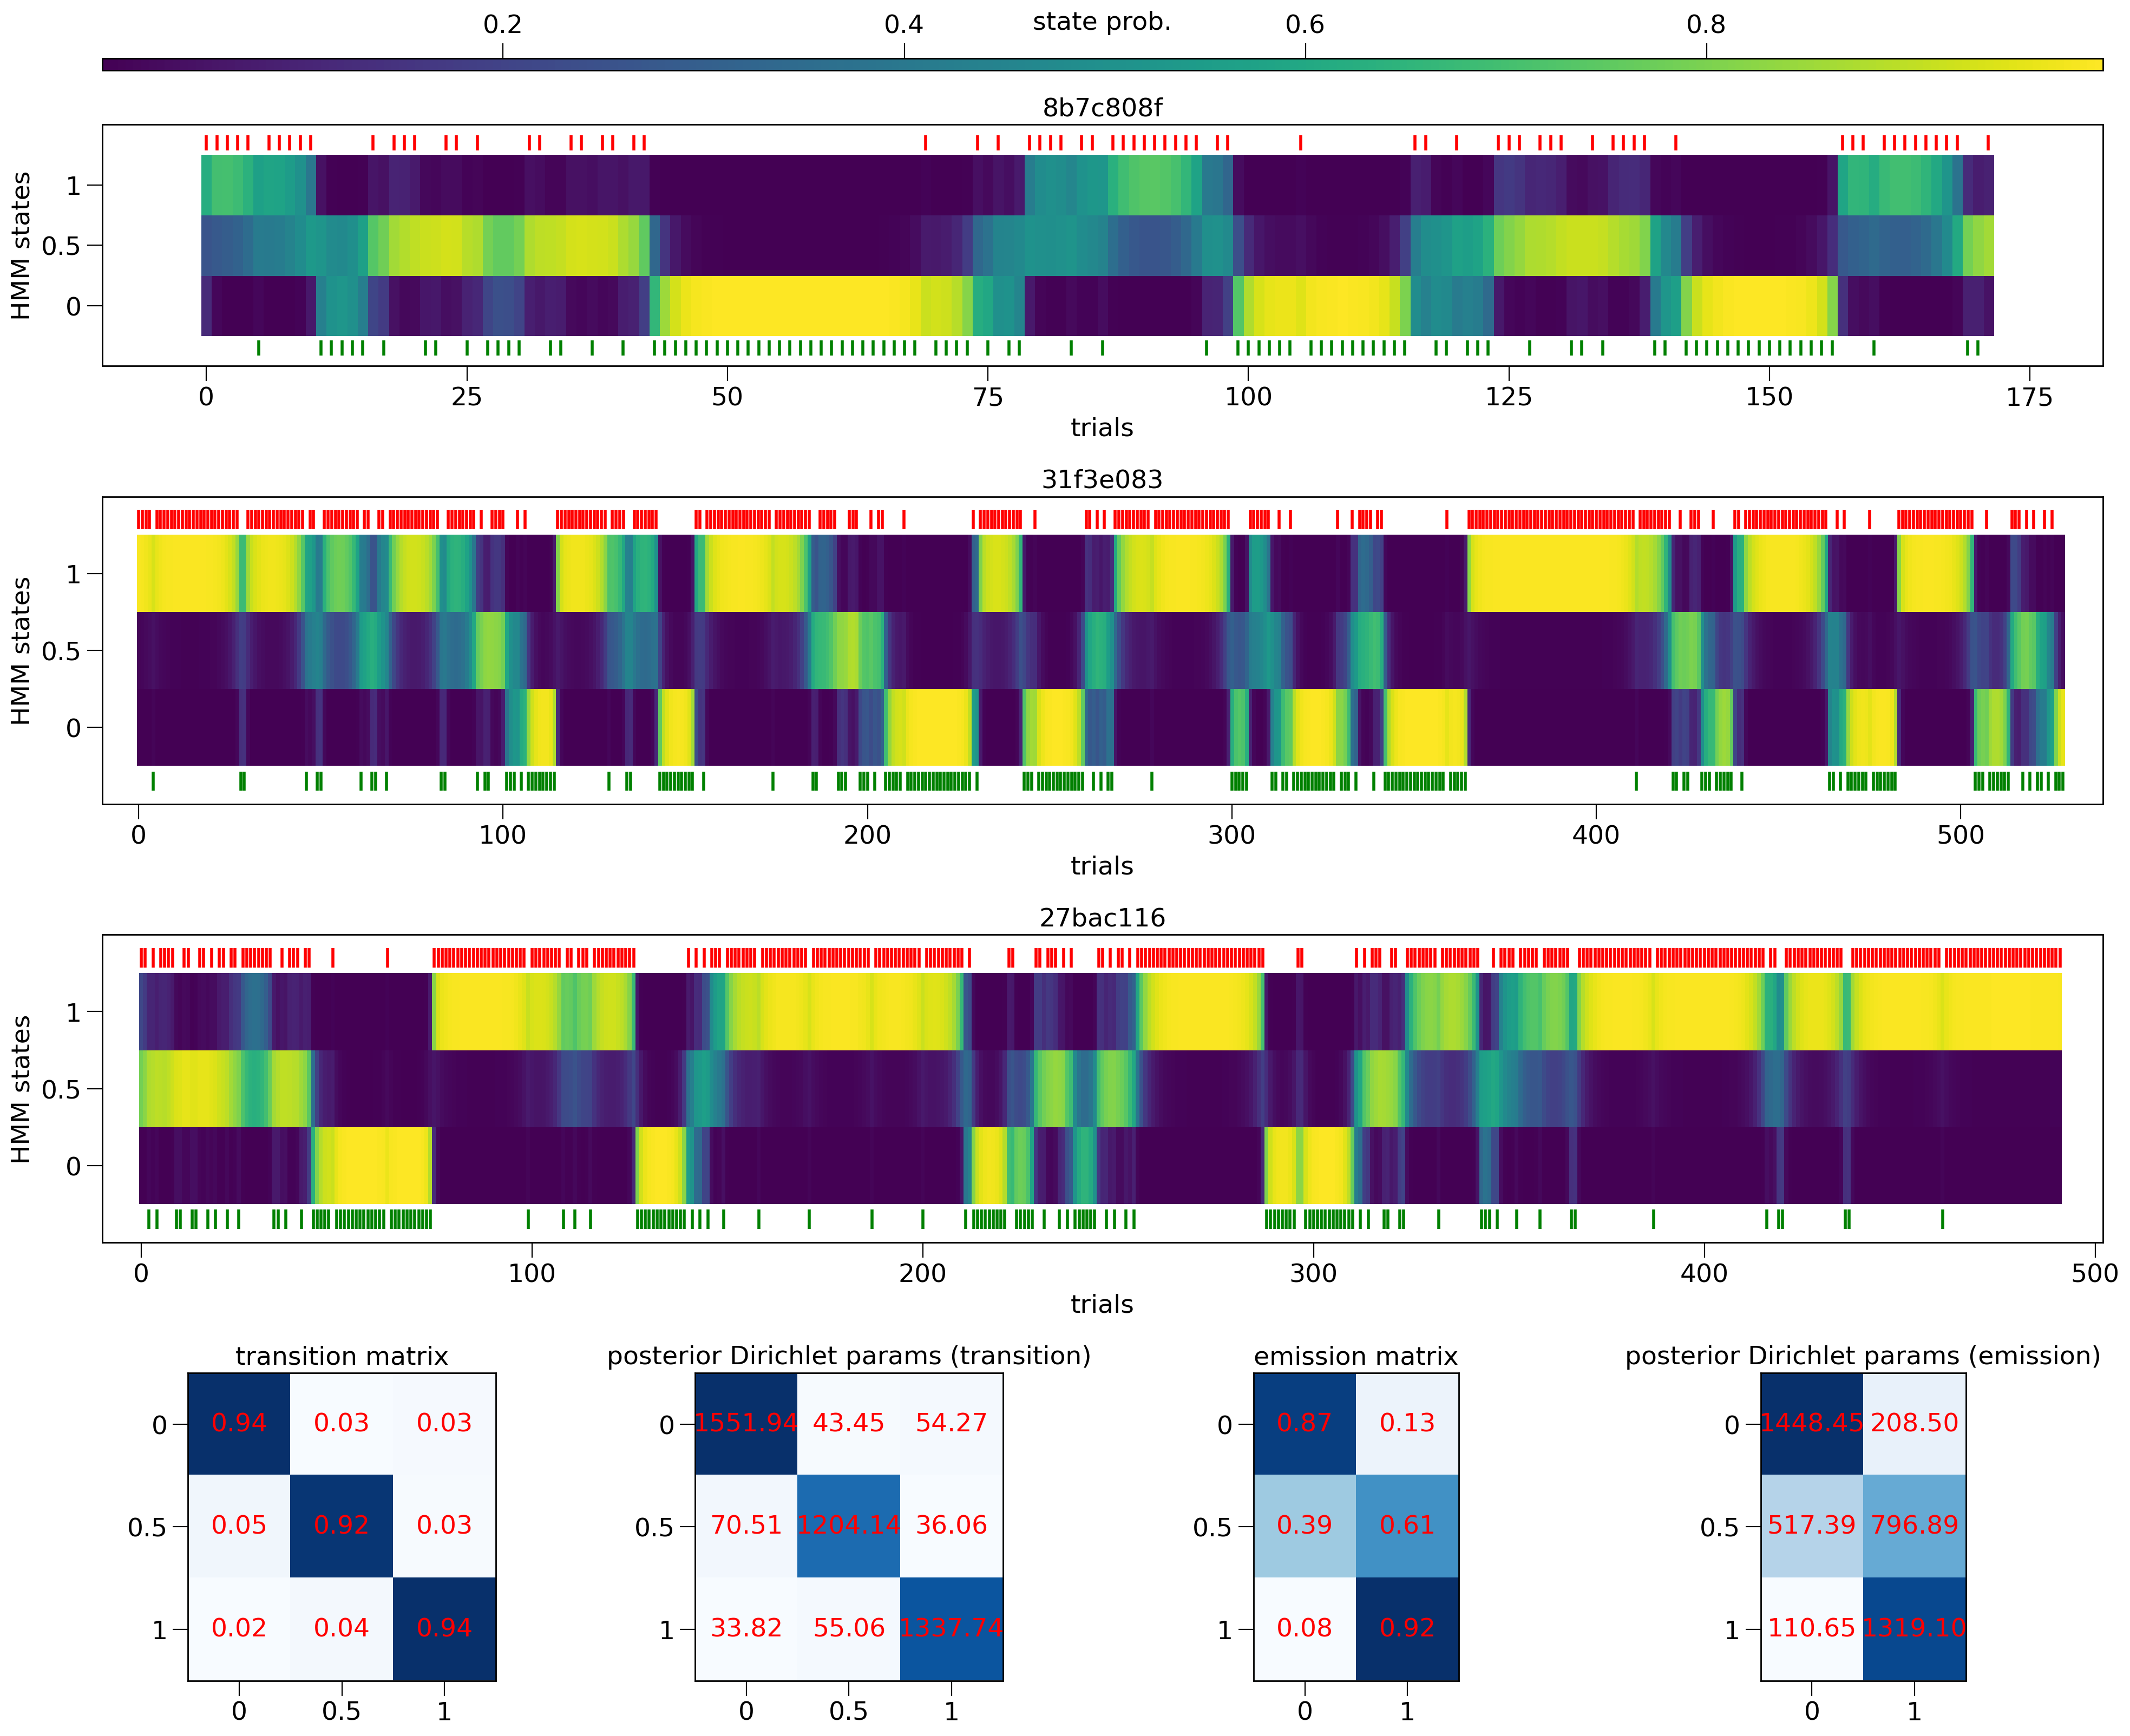

In [6]:
# fit variational hmm 

multi_sess_hmm = vhmm.VariationalCategoricalHMM(n_components=3)
multi_sess_hmm.fit(aligned_train_ys, lengths)

aligned_train_states = multi_sess_hmm.predict_proba(aligned_train_ys)
multi_sess_trial_idxs = np.cumsum([0] + lengths)

train_states = [
    aligned_train_states[multi_sess_trial_idxs[i-1]:multi_sess_trial_idxs[i]] for i in range(1, len(multi_sess_trial_idxs))
]

a_constraint = multi_sess_hmm.transmat_
b_constraint = multi_sess_hmm.emissionprob_
pi_posterior = multi_sess_hmm.startprob_posterior_
a_posterior = multi_sess_hmm.transmat_posterior_
b_posterior = multi_sess_hmm.emissionprob_posterior_

# manually check quality of vhmm fit
plot_multi_session_hmm_results(
    states=train_states,
    choices=train_ys,
    pids=np.array(pids)[train_pid_idxs],
    params=(a_constraint, b_constraint, a_posterior, b_posterior)
)

In [7]:
# fit bmm 

train_ds_flat = np.vstack(train_ds).squeeze()
train_ys_flat = np.vstack(train_ys).squeeze()

with pm.Model() as beta_model:
    eta = pm.Gamma("eta", alpha = 5, beta = 1, shape = 2)
    nu = pm.Gamma("nu", alpha = 1, beta = 5, shape = 2)
    # pymc uses rate lambda but scipy uses scale=1/lambda
    alpha = pm.Exponential("a", eta, shape = 2)
    beta = pm.Exponential("b", nu, shape = 2)
    dk = BetaProcess('d', train_ys_flat, alpha, beta, observed=train_ds_flat)
    step = pm.NUTS()     
    trace = pm.sample(draws=1000, step=step, chains=2, progressbar=True)  
    beta_ppc = pm.sample_posterior_predictive(
        trace, var_names=["a", "b", "d", "eta", "nu"], random_seed=seed
    )

a0, a1 = beta_ppc["a"].mean(0)
b0, b1 = beta_ppc["b"].mean(0)
a0_prior, a1_prior = beta_ppc["eta"].mean(0)
b0_prior, b1_prior = beta_ppc["nu"].mean(0)
print([a0, b0, a1, b1])
print([a0_prior, b0_prior, a1_prior, b1_prior])

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a, nu, eta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


[0.45775786878661867, 0.6412427985170407, 0.7376262428171941, 0.4043977481276848]
[4.145054388338552, 0.3546643059650212, 3.412319635736175, 0.3706060553870131]


In [8]:
# initialize bmm-hmm

startprob = multi_sess_hmm.startprob_
pi_prior = multi_sess_hmm.startprob_posterior_
a_prior = multi_sess_hmm.transmat_posterior_
phi_prior = multi_sess_hmm.emissionprob_posterior_

states = [0, 1, 2]
init_pi = {0: np.log(startprob[0]), 1:np.log(startprob[1]), 2: np.log(startprob[2])}
init_a = {
        0: {0: np.log(a_constraint[0][0]), 1: np.log(a_constraint[0][1]), 2: np.log(a_constraint[0][2])},
        1: {0: np.log(a_constraint[1][0]), 1: np.log(a_constraint[1][1]), 2: np.log(a_constraint[1][2])},
        2: {0: np.log(a_constraint[2][0]), 1: np.log(a_constraint[2][1]), 2: np.log(a_constraint[2][2])} }
init_phi = {
        0: {0: np.log(b_constraint[0][0]), 1: np.log(b_constraint[0][1])},
        1: {0: np.log(b_constraint[1][0]), 1: np.log(b_constraint[1][1])},
        2: {0: np.log(b_constraint[2][0]), 1: np.log(b_constraint[2][1])}
         }
init_beta_a = [a1, a0]
init_beta_b = [b1, b0]

beta_a_prior = [a1_prior, a0_prior]
beta_b_prior = [b1_prior, b0_prior]

In [9]:
# fit bmm-hmm
bmm_hmm = Constrained_BMM_HMM(
    d, 
    init_pi, 
    init_a, 
    init_phi, 
    init_beta_a, 
    init_beta_b, 
    pi_prior, 
    a_prior, 
    phi_prior,
    beta_a_prior, 
    beta_b_prior,
    tol=1e-1
)
bmm_hmm.update(d)

BMM Convergence Achieved:  True
log-likelihood: 92.97411877326358
BMM Convergence Achieved:  True
log-likelihood: 93.16567690357847
BMM Convergence Achieved:  True
log-likelihood: 93.14021848948515


In [10]:
a_hat = bmm_hmm.a
phi_hat = bmm_hmm.phi
beta_a_hat = bmm_hmm.beta_a
beta_b_hat = bmm_hmm.beta_b

In [11]:
# inference

A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)

B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(d)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
post_preds, post_probs = posterior_inference(bmm_hmm, d)

save_metrics.update({
    "acc": {
        "baseline": accuracy_score(y, [1 if d_k > .5 else 0 for d_k in d]),
        "bmmhmm": accuracy_score(y, post_preds)
    }
})
save_metrics.update({
    "auc": {
        "baseline": roc_auc_score(y, d),
        "bmmhmm": roc_auc_score(y, post_probs)
    }
})
save_metrics.update({
    "corr": {
      "baseline": pointbiserialr(y, d)[0],
      "bmmhmm": pointbiserialr(y, post_probs)[0]
    },
})

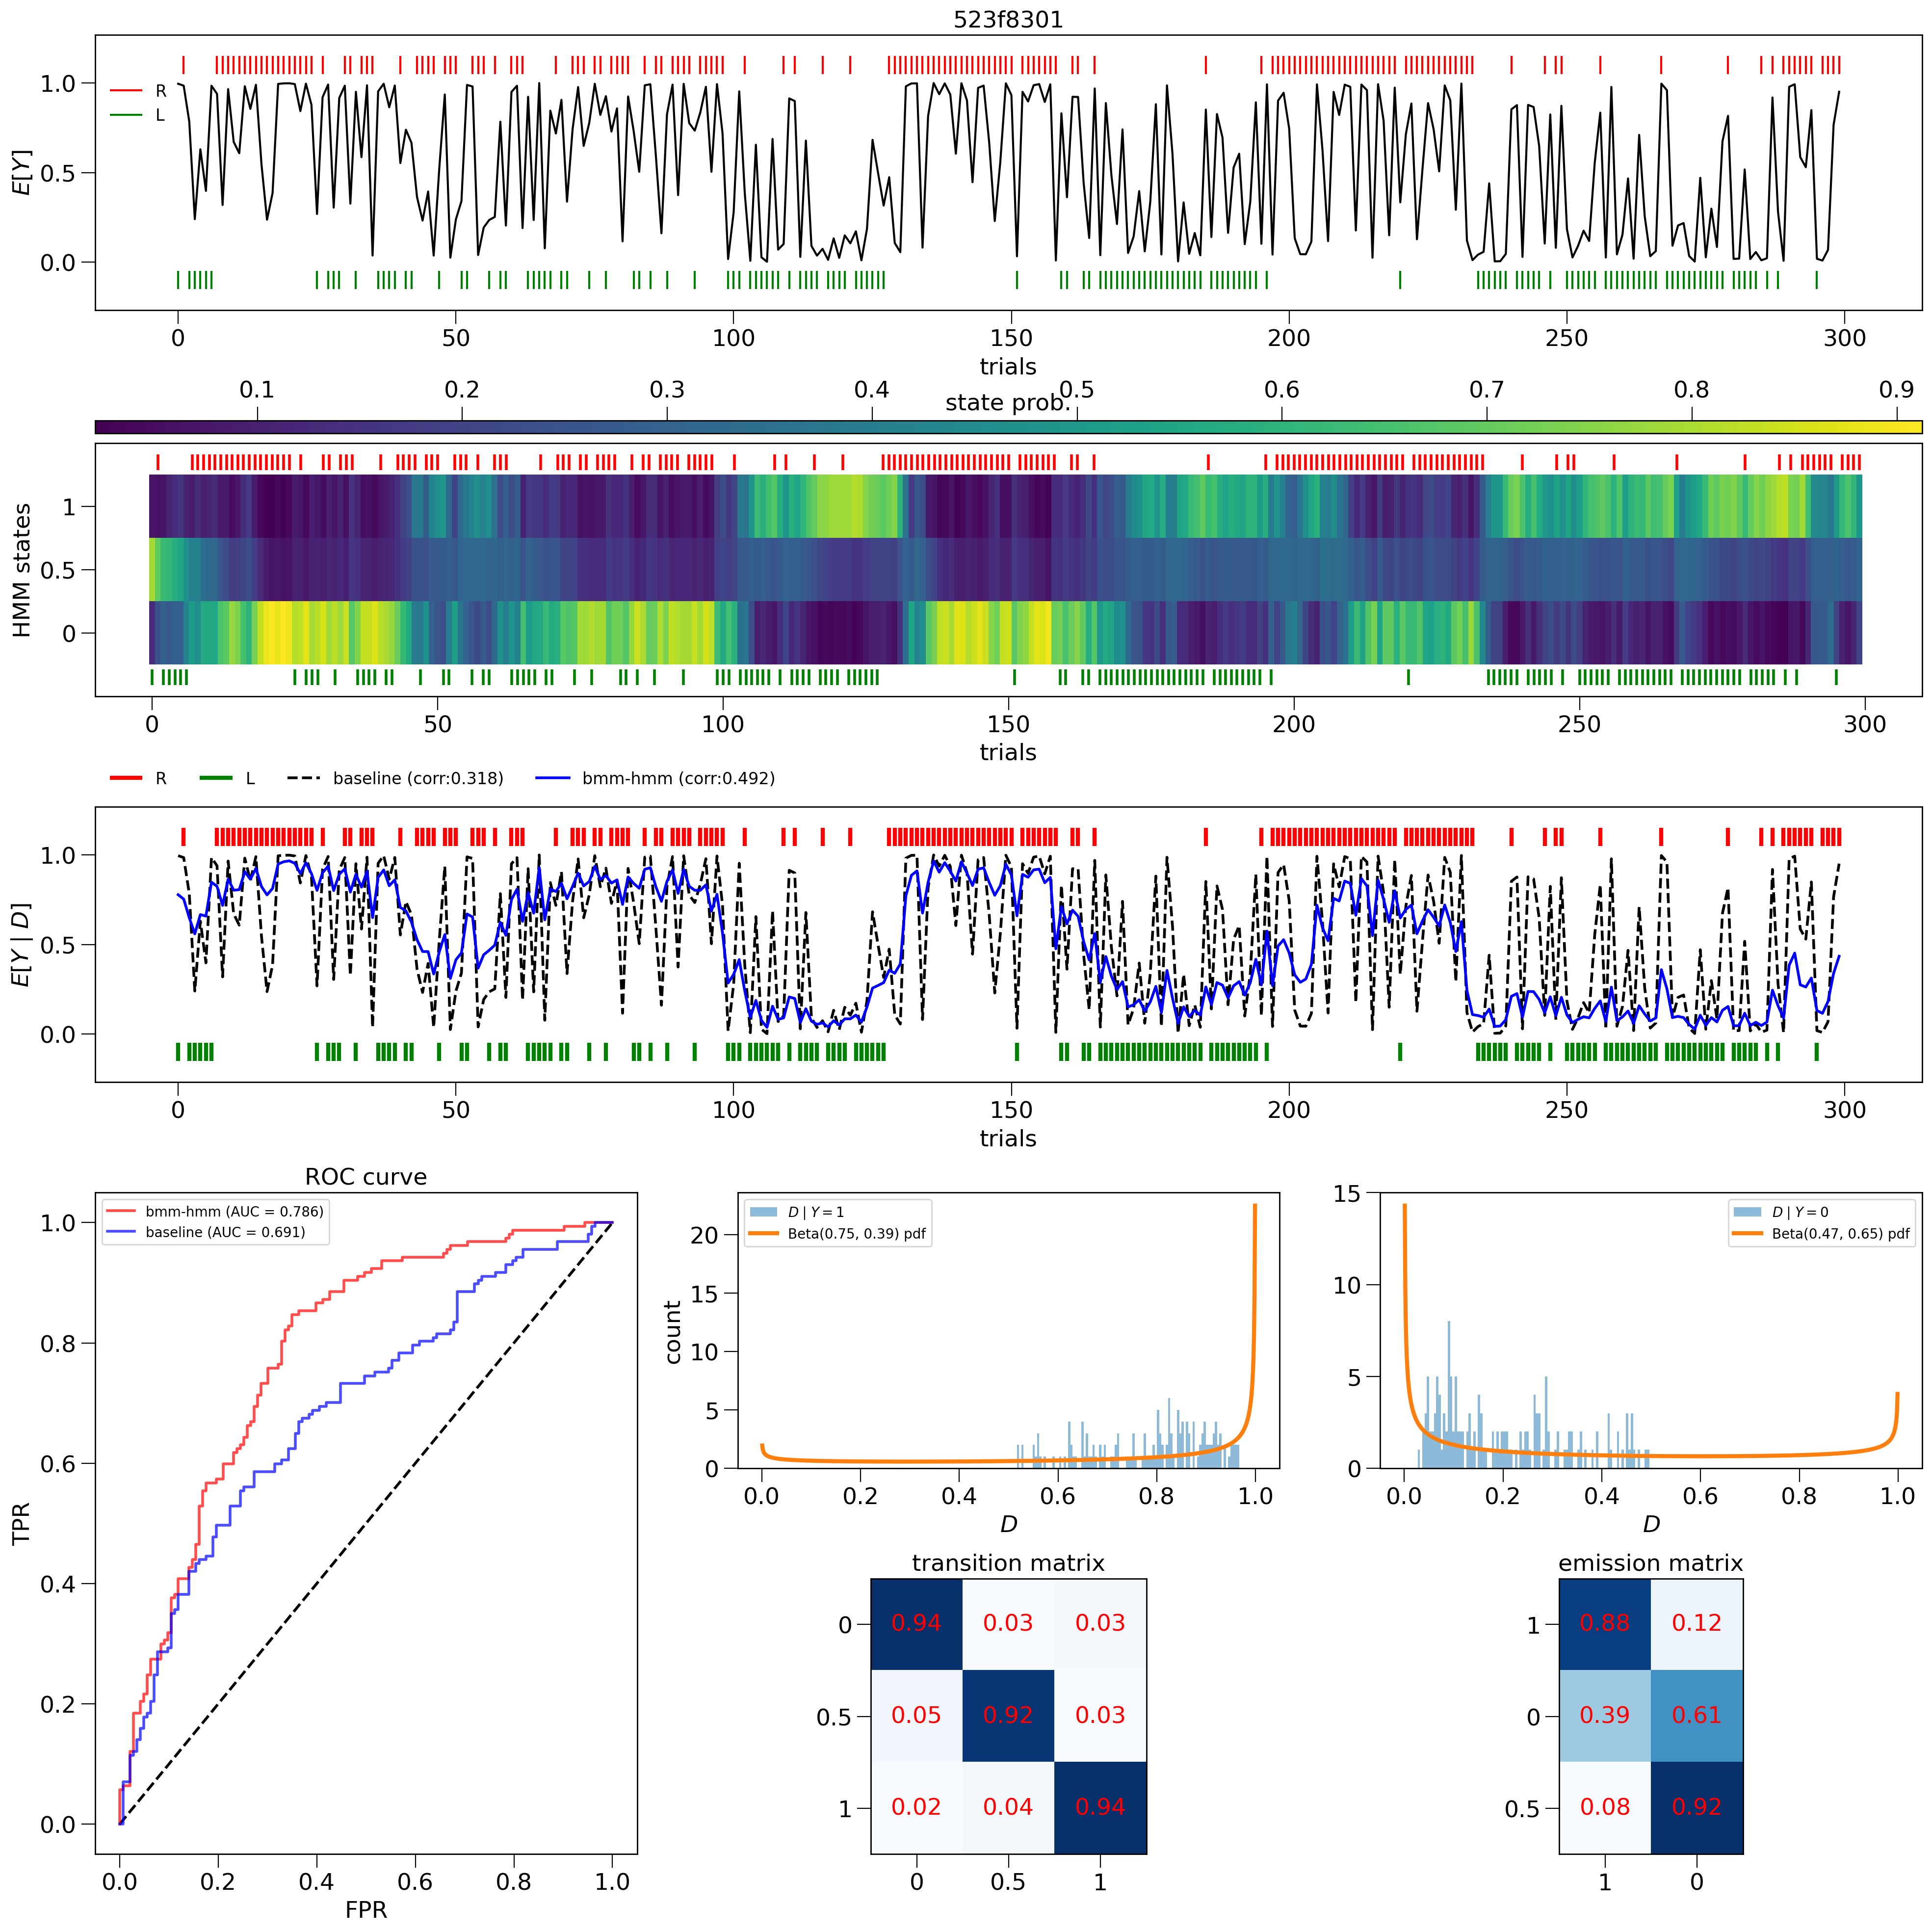

In [12]:
plot_bmm_hmm_results(
    estimates=d,
    post_preds=post_preds,
    post_probs=post_probs,
    states=states,
    choices=y,
    params=(A, B, beta_a_hat, beta_b_hat),
    save_metrics=save_metrics,
    pid=pid,
    brain_region=brain_region
)

In [ ]:
estimates = d.copy()
choices = y.copy()

fig = plt.figure(figsize=(20, 6))
gs = GridSpec(2, 1, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

# show inferred states from decoder estimates
im = ax1.imshow(np.c_[states.T[-1], states.T[1], states.T[0]].T, aspect="auto", cmap="viridis")
ax1.eventplot(np.where(choices == 1.), colors="r", lineoffsets=2.7, linelengths=.25, linewidth=2., label="R")
ax1.eventplot(np.where(choices == 0.), colors="g", lineoffsets=-.7, linelengths=.25, linewidth=2., label="L")
# ax1.set_ylabel("behavioral state")
ax1.set_yticks([0, 1, 2.0], ["L", "M", "R"])
ax1.set_xticks([0, 100, 150, 200, 300], [0, 100, "trial", 200, 300])
ax1.set_ylim(-1, 3.)
ax1.set_xlim(-10, len(states)+10.)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("top", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position("top")
# cbar.set_label(r"$E[S_k \mid \vec{D}]$", labelpad=-40)
cbar.ax.set_xticks([0.05, 0.3, 0.5, 0.6, 0.9], [0., 0.3, "behavioral state prob.", 0.6, 0.9]) 
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)

# show smoothed decoder estimates
ax2.eventplot(np.where(choices == 1.), colors="r", lineoffsets=1.1, linelengths=.1, linewidth=3.)
ax2.eventplot(np.where(choices == 0.), colors="g", lineoffsets=-.1, linelengths=.1, linewidth=3.)
ax2.plot(estimates, c="gray", linestyle="-", linewidth=1.5, label=f"single-trial + single session (AUC = {save_metrics['auc']['baseline']:.3f})")
ax2.plot(post_probs, c="royalblue", linestyle="-", linewidth=3, label=f"multi-trial + multi-session (AUC = {save_metrics['auc']['bmmhmm']:.3f})")
# ax2.set_ylabel(r"$E[Y_k \mid \vec{D}]$")
ax2.set_yticks([0, 0.5, 1.0], ["L", "M", "R"])
ax2.set_xticks([0, 100, 150, 200, 300], [0, 100, "trial", 200, 300])
ax2.legend(ncols=4, loc='center left', bbox_to_anchor=(-0., 1.1), fontsize=20, frameon=False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(True)

plt.tight_layout()
fig.subplots_adjust(hspace=.5)
# plt.savefig("./plots/bmm_hmm_states_decoded_traces.png", dpi=400)
plt.show()